# First trial in 5 steps
- 1. Design some variable system with differential equation
- 2. Discretize
- 3. Simulate over time
- 4. Make an ESN learn to generate next output
- 5. Then, try to find the original equations inside the reservoir
    - Plot internal states
    - Or jsut try to find out parameters ?

# Notes
- Interractions can only be understood by the ESN within a precise context defined by the echo of a sufficiently long input

## 0. Some useful functions

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# Store a run
dic_run = {
    'Run results': ['mse_train','mse_sim'],
    'Parameters' : ['N','r','var_noise', 'rand_W', 
                    'scarcity', 'param_rand_W', 'Fl', 'Tr', 'Si', 'Tt'],
    'Simulation params': ['a','b', 'c', 'd', 'dt', 'T']
}

def store_dic_run(dic_run=dic_run, fname='store_runs.md'):
    now = datetime.datetime.now().strftime("%d:%m:%Y:_:%H:%M:%S")
    with open(fname, 'a') as file:
        file.write(f'# Run {now}\n')
        for key, variables in dic_run.items():
            file.write(f'## {key}\n')
            for variable in variables:
                file.write(f'- {variable}: {globals()[variable]}\n')
    plt.savefig(f'img/run{now}.jpg')

In [6]:
# Get appropriate colors
from matplotlib import colors as mcolors
from matplotlib import cm
import matplotlib

# colors = [c for n, c in matplotlib.colors.cnames.items()]
# cmap = cm.get_cmap('seismic', 5)  # matplotlib color palette name, n colors

cmap = cm.get_cmap('hsv', 22)
colors = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for  i in range(cmap.N)]
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)

## 1.Design some variable system with differential equations
### Latka Volterra for simplicity
$\frac{\partial x}{\partial t} = \alpha x - \beta x y$

$\frac{\partial y}{\partial t} = \gamma x y - \delta y$

## 2. Discretize

In [7]:
def xn(x, y):
    """Returns next x"""
    return x + a*x*dt - b*x*y*dt

def yn(x, y):
    """Returns next y """
    return y + c*x*y*dt - d*y*dt

## 3. Simulate

In [8]:
# Parameters
a, b, c, d = 2/3, 4/3, 1, 1
dt = 0.08
x0, y0 = 1.2, 1.2
T = 1000

In [9]:
X = np.zeros(T)
Y = np.zeros(T)

# Init 
X[0], Y[0] = x0, y0

# Increment
for i in range(1, T):
    X[i] = xn(X[i - 1], Y[i-1])
    Y[i] = yn(X[i - 1], Y[i-1])

Text(0.5, 1.0, 'Simulation')

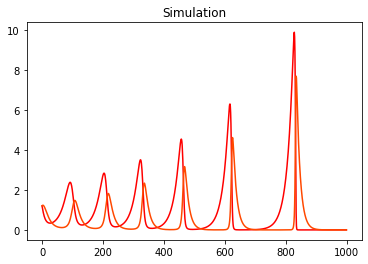

In [10]:
# Plot
plt.plot(X)
plt.plot(Y)
plt.title("Simulation")

### <font color='red'> NOTE: Not precise, use runge kutta</font>

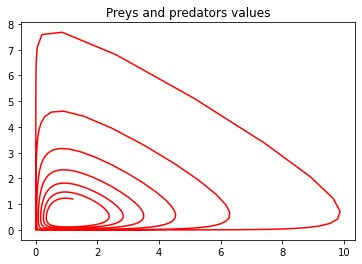

In [11]:
plt.plot(X, Y)
plt.title("Preys and predators values");

## 2., 3. BIS with integration module
Better with scipy integrators

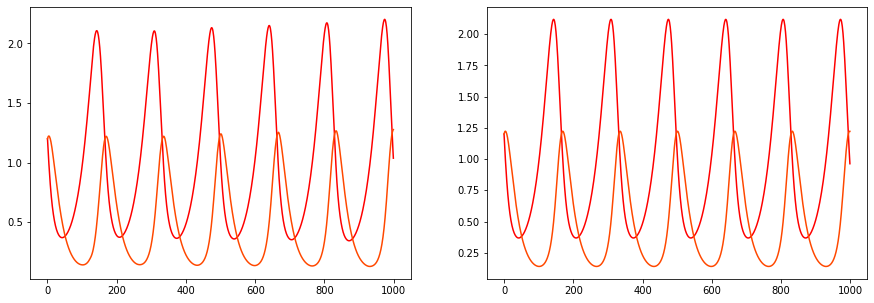

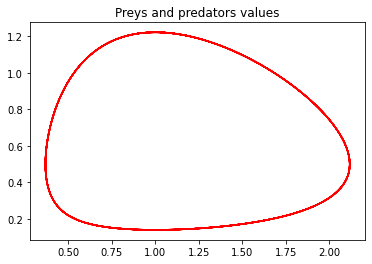

In [14]:
from scipy.integrate import solve_ivp, odeint
ttt = np.linspace(0, 50, T)

plt.figure(figsize=(15,5))
plt.subplot(121)
def deriv_ivp(t, xy):
    x, y = xy
    return np.array([a*x - b*x*y, c*x*y - d*y])
plt.plot(solve_ivp(deriv_ivp, [min(ttt), max(ttt)], [x0, y0], t_eval=ttt).y.T);

plt.subplot(122)
def deriv_odeint(xy, t):
    x, y = xy
    return np.array([a*x - b*x*y, c*x*y - d*y])
plt.plot(odeint(deriv_odeint, [x0, y0], ttt));

X, Y = odeint(deriv_odeint, [x0,y0], ttt).T
plt.figure()
plt.plot(X, Y)
plt.title("Preys and predators values");

## 4. ESN learning

In [330]:
from numpy import tanh, arctanh, dot

In [382]:
# Parametrs
## Neurons number
K = 0
N = 20
L = 2

## Periods
Fl = 100
Tr = 500
Si = 400
Tt = Fl + Tr + Si

## Activation functions
f_dr = lambda x: tanh(x)
f_out = lambda x: x
inv_f_out = lambda x: x

## Other
r = 0.95 # Spectral radius
var_noise = 0.001 # Variance of random noise

In [383]:
# Random functions for internal weights
def rand_W_sample(size, cst=0.4, scarcity=0.6):
    probs = [scarcity, (1-scarcity)/2, (1-scarcity)/2]
    Wr = np.random.choice([0, -cst, cst], size=size, replace=True, p=probs)
    try:
        return Wr/max(abs(np.linalg.eigvals(Wr)))
    except:
        print('NORM bc not squared matrix')
        return Wr/np.linalg.norm(Wr)

def rand_W_unif(size, cst=0.4, scarcity=0.6):
    Wr = np.random.sample(size)*2*cst - cst
    mask = np.random.choice([0, 1], size=size, replace=True, p=[scarcity, 1-scarcity])
    Wr = mask*Wr
    return Wr/max(abs(np.linalg.eigvals(Wr)))
    
def rand_W_normal(size, var=1, scarcity=0.6):
    Wr = np.random.normal(0, var, size=size)
    mask = np.random.choice([0, 1], size=size, replace=True, p=[scarcity, 1-scarcity])
    Wr = mask*Wr
    return Wr/max(abs(np.linalg.eigvals(Wr)))


In [384]:
# Weights
W_back = rand_W_sample((N,L), scarcity=0)

param_rand_W = 0.4
scarcity = 0.9
rand_W = rand_W_sample
W = rand_W((N,N), param_rand_W, scarcity)*r

NORM bc not squared matrix


In [385]:
# Sample
data = np.vstack((X,Y)).T
io_data = np.array([inv_f_out(d) for d in data]) # Inverse out data

M = np.zeros((Tt, N))
# M # INIT if you want
for i in range(1, Fl + Tr):
    noise = np.random.normal(0, var_noise, size=N)
    M[i,:] = f_dr(dot(W, M[i-1,:]) + dot(W_back, io_data[i-1,:]) + noise)

### <font color='red'>NOTE: Data out of range of tanh</font>

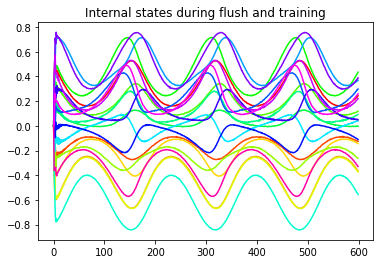

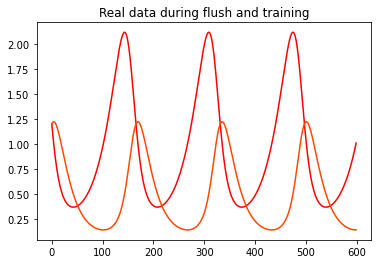

In [386]:
# Plot internal states
plt.plot(M[: Fl + Tr]);
plt.title("Internal states during flush and training");
plt.figure()
plt.plot(io_data[: Fl + Tr]);
plt.title("Real data during flush and training");

In [387]:
# Learn
W_out = dot(np.linalg.pinv(M[Fl: Fl + Tr]), io_data[Fl: Fl + Tr])

Text(0.5, 1.0, 'Real and trained data')

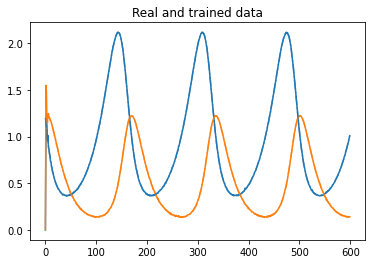

In [388]:
# Plot learned
plt.gca().set_prop_cycle(color=['tab:blue','tab:orange','tab:blue','tab:orange'])
plt.plot(dot(M[: Fl + Tr], W_out));
plt.plot(io_data[: Fl + Tr], linestyle='-.', alpha=0.7)
plt.title("Real and trained data")

In [389]:
# Simulate
Z = np.zeros((Tt, L))
Z[: Fl + Tr,:] = dot(M[: Fl + Tr], W_out)
for i in range(Fl + Tr, Tt):
    M[i] = f_dr(dot(W, M[i-1,:]) + dot(W_back, Z[i-1,:]))
    Z[i] = f_out(dot(M[i,:], W_out))

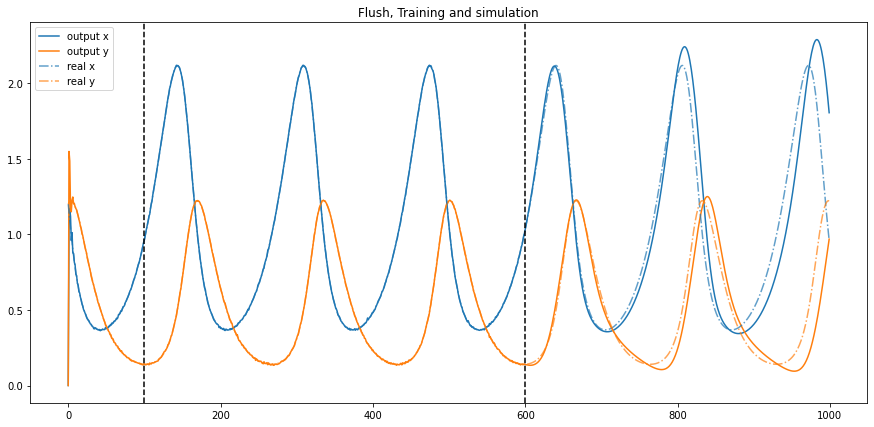

In [402]:
# Plot simulation vs real
plt.subplots(figsize=(15,7))
plt.gca().set_prop_cycle(color=['tab:blue','tab:orange','tab:blue','tab:orange'])
plt.plot(Z);
plt.plot(data[:Tt], linestyle='-.', alpha = 0.7)
plt.axvline(Fl + Tr, linestyle='--', color='black');
plt.axvline(Fl, linestyle='--', color='black');
plt.legend(['output x', 'output y', 'real x', 'real y'])
plt.title("Flush, Training and simulation")
if False:
    store_dic_run();

Mean of internal states: 0.0204 (train), 0.0214 (simulation)
Mean of W_out: 0.0726


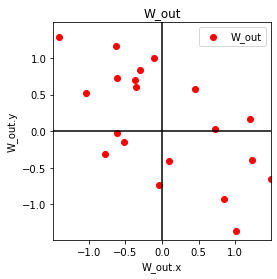

In [417]:
# Plot W_out
plt.scatter(*W_out.T)
plt.legend(['W_out'])
plt.axvline(0, color='black')
plt.axhline(0, color='black')
plt.axis('square')
m = max(W_out.flatten())
plt.xlim((-m, m))
plt.ylim((-m, m));
plt.xlabel('W_out.x')
plt.ylabel('W_out.y')
plt.title('W_out');

print(f'Mean of internal states: {M[Fl: Fl + Tr].mean():.4f} (train), {M[Fl + Tr: ].mean():.4f} (simulation)')
print(f'Mean of W_out: {W_out.mean():.4f}')

### Notes
- Doesn't work every time. Does it indicates a poor learning, overfiting ?

# 5. ...
## 5.1 Reservoir exploration

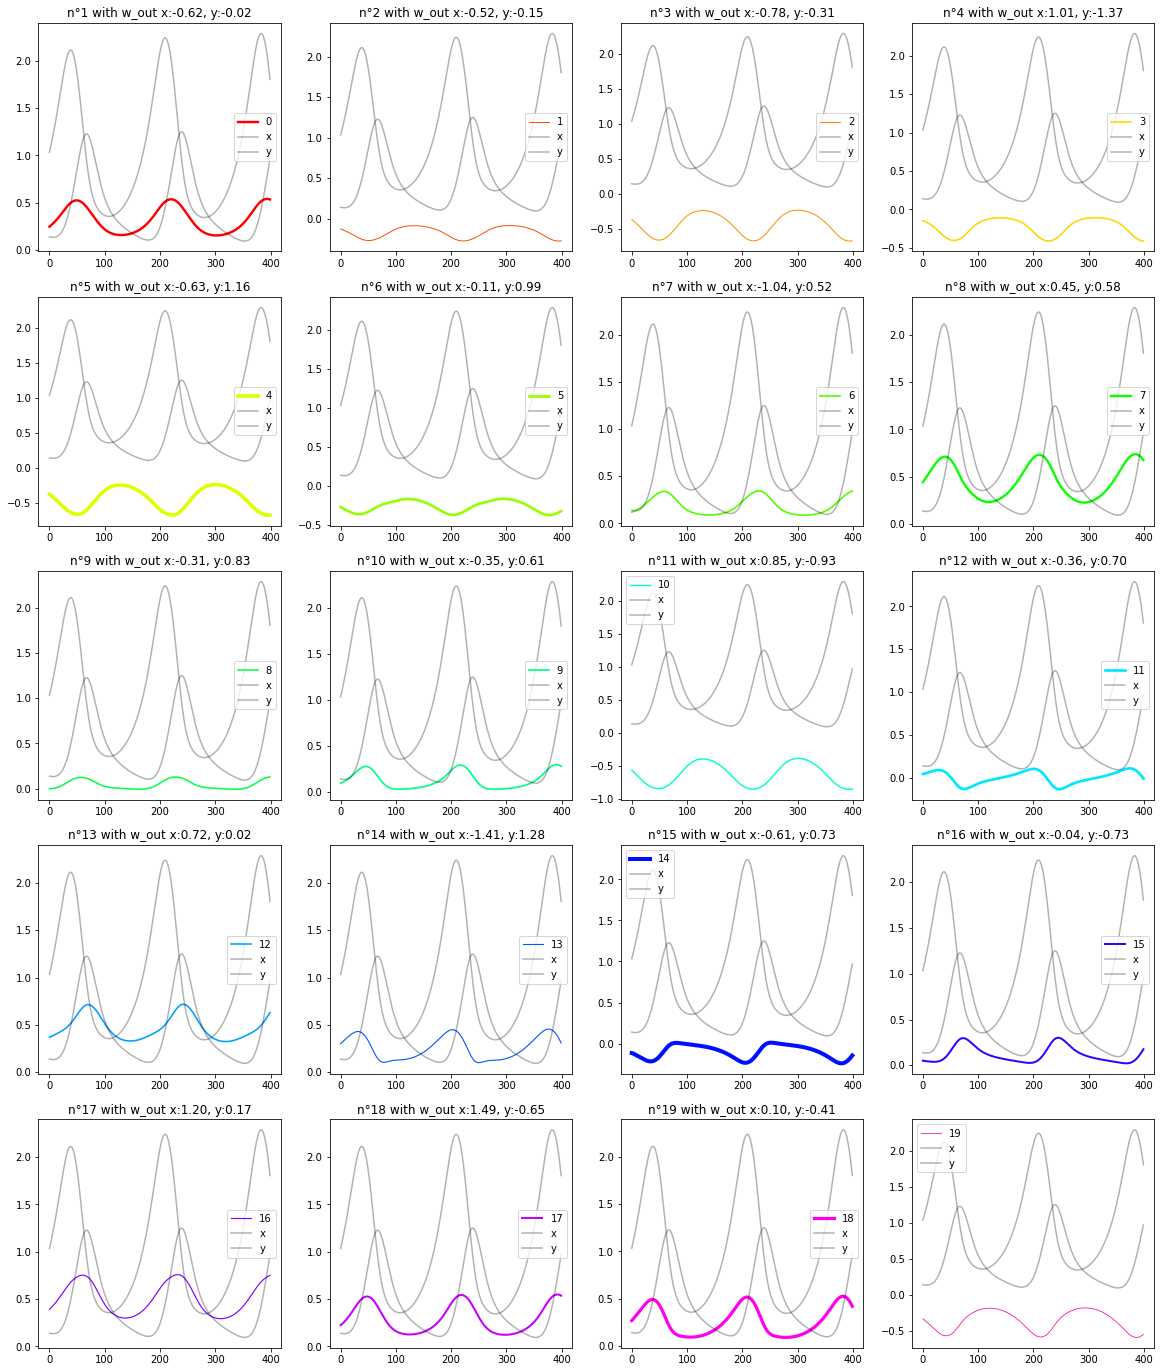

In [512]:
# Observe internal states, all different plot
nb_per_line=4
plt.figure(figsize=(nb_per_line*5,N//nb_per_line*20))
for i in range(N):
    plt.title(f'n°{i} with w_out x:{W_out[i, 0]:.2f}, y:{W_out[i, 1]:.2f}')
    plt.subplot(N, nb_per_line, i+1)
    plt.plot(M[Fl + Tr: ,i], linewidth=abs(W_out).mean(axis=1)[i]*3, color=colors[i]);
    plt.plot(Z[Fl + Tr: ], color = 'black', alpha = 0.3);
    plt.legend([i]+ ['x','y'])

Text(0.5, 1.0, 'Internal states evolution, width in function of their W_out importance')

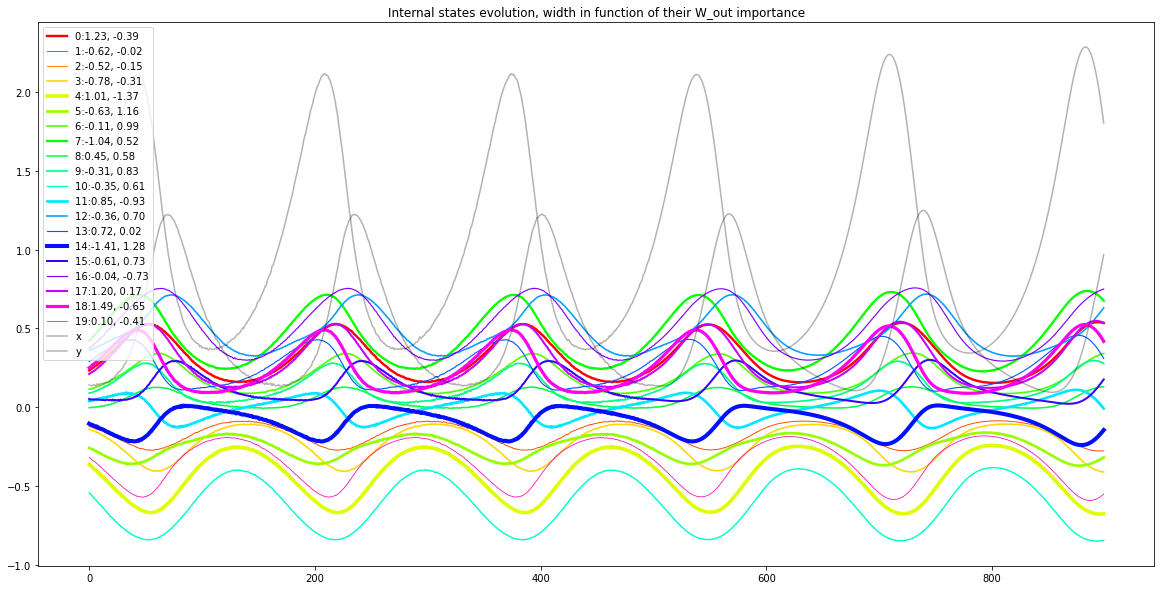

In [515]:
# Observe internal states, all same plot
plt.figure(figsize = (20,10))
for i in range(N):
    plt.plot(M[Fl: ,i], linewidth=abs(W_out).mean(axis=1)[i]*3, color=colors[i]);
plt.plot(Z[Fl: ], color = 'black', alpha = 0.3);

plt.legend([f'{i}:{W_out[i,0]:.2f}, {W_out[i,1]:.2f}' for i in range(N)]+ ['x','y'], loc='upper left')
plt.title('Internal states evolution, width in function of their W_out importance')

Text(0.5, 1.0, 'W_out weights in x (upper part) and y (lower part)')

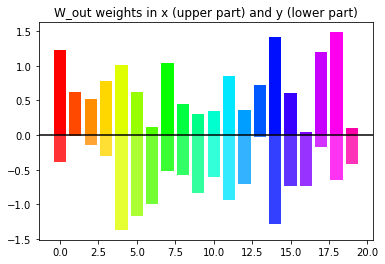

In [487]:
# Get w_out weights
plt.bar(range(N), abs(W_out.T[0]), color=colors)
# plt.bar(range(N), abs(W_out.T[1]), bottom=abs(W_out.T[0]), color=colors, alpha=0.5)
plt.bar(range(N), -abs(W_out.T[1]), color=colors, alpha=0.8)
plt.axhline(y=0, color='black');
plt.title('W_out weights in x (upper part) and y (lower part)')

## Notes
- Important values for x seems to indicate the same for y 

In [456]:
min(np.array(list(pos.values())).T[0])

-0.6364871440371371

In [479]:
sum(sum(W!=0)),ordered_edge_weights.shape

(42, (42,))

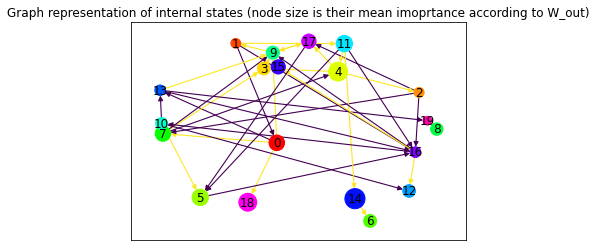

In [488]:
# Visualize graph 
import networkx as nx
G = nx.DiGraph(W.T) # Transposed bc: state 1 is updated by line 1
pos = nx.spring_layout(G)

# Add output neurs
# W_with_out = np.vstack((np.hstack((W, W_back)), np.hstack((W_out.T, np.zeros((2,2))))))
# G_with_out = nx.DiGraph(W_with_out.T)
# right = max(np.array(list(pos.values())).T[0])
# pos[N] = [right + 1, 1]
# pos[N + 1] = [right + 1, -1]

# edgelist
ordered_edge_weights = np.array([w for i, j , w in G.edges(data='weight')])
factor_width = 2

node_sizes = abs(W_out).mean(axis=1)

factor_node_size = 300
nx.draw_networkx(G, pos, 
                 # Edges
                 width=abs(ordered_edge_weights)*factor_width, 
                 edge_color=ordered_edge_weights,
                 # Nodes
                 node_size=abs(node_sizes)*factor_node_size,
                 with_labels=True,
                 node_color=colors[:N] #+ ['white', 'white']
                )
plt.title('Graph representation of internal states (node size is their mean imoprtance according to W_out)');

## Notes
- Could we make this reservoir more :
    - Rich: with arragements of neurons that could lead to rich combinations
    - Readable: with more "small worlds", like a gathering of several modulus easy to analyse
- Does a large value of W_out indicates an important neuron ?

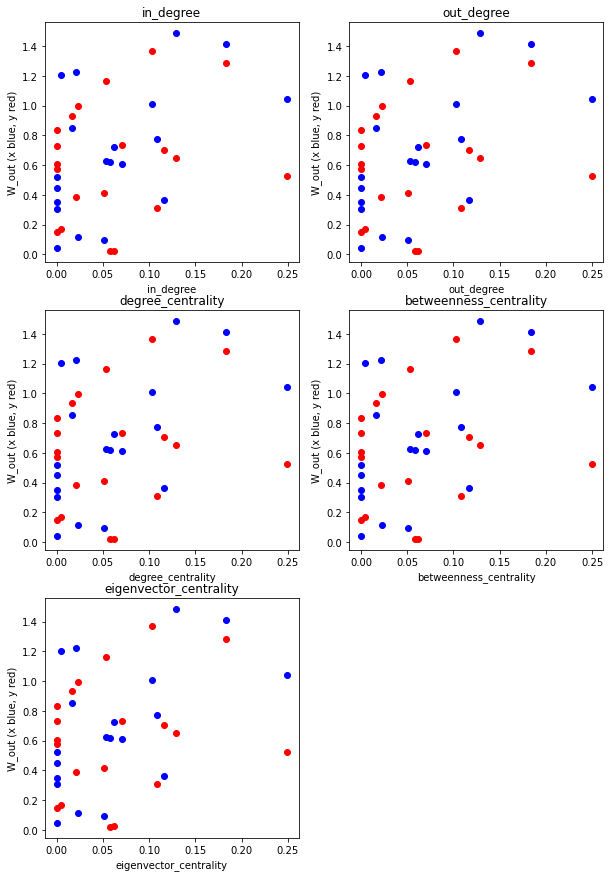

In [516]:
# Degrees
G = nx.DiGraph(W.T)

W_with_out = np.vstack((np.hstack((W, W_back)), np.hstack((W_out.T, np.zeros((2,2))))))
G_with_out = nx.DiGraph(W_with_out.T)
G = G_with_out

plt.figure(figsize=(10,15))
for i, (measure_name, measure) in enumerate([
    ('in_degree', [d for n, d in G.in_degree]),
    ('out_degree', [d for n, d in G.out_degree]),
    ('degree_centrality', nx.degree_centrality(G).values()),
    ('betweenness_centrality', nx.betweenness_centrality(G).values()),
    ('eigenvector_centrality', nx.eigenvector_centrality(G).values())]):
    plt.subplot(3, 2, i+1)
    plt.scatter(centrality, abs(W_out.T[0]), color='blue')
    plt.scatter(centrality, abs(W_out.T[1]), color='red')
    plt.title(measure_name)
    plt.xlabel(measure_name)
    plt.ylabel('W_out (x blue, y red)')

## Notes
- The relation between degree and importance is not clear